In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
import nibabel as nib
from os.path import join
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import sys
sys.path.append('../general_functions/')
from plotting_brains_surfplot import map_values_to_atlas,  make_translucent_map, Plot
from nilearn import datasets, plotting


/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [8]:
from surfplot.surf import plot_surf
#from surfplot import Plot -- importing modified Class
from brainspace.datasets import load_parcellation
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
atlas_surf = load_parcellation('schaefer', 100, join = True)


from matplotlib.colors import LinearSegmentedColormap


basic_cols=['k', 'k', 'k']
black_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
basic_cols=['darkblue', 'darkblue', 'darkblue']
blue_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

# Combine them

In [3]:
def try_int(val):
    try:
        return int(val) - 1
    except ValueError:
        return val



In [14]:

def fdr_correction_with_exclusions(
    df,
    p_value_col,
    estimate_col=None,
    alternative="two-sided",
    exclude_indices=[30, 31, 32, 78, 79]
):
    """
    Apply FDR correction to p-values, handling NaNs and explicit exclusions.
    """

    if isinstance(p_value_col, list):
        p_values = df[p_value_col].iloc[:, 0].values.astype(float)
    else:
        p_values = df[p_value_col].values.astype(float)

    # --- optional one-sided adjustment --- Not using it! 
    if alternative != "two-sided":
        if estimate_col is None:
            raise ValueError("estimate_col must be provided for one-sided tests")

        estimates = df[estimate_col].values.astype(float)

        if alternative == "greater":
            p_values = np.where(estimates > 0, p_values / 2, 1.0)
        elif alternative == "less":
            p_values = np.where(estimates < 0, p_values / 2, 1.0)
        else:
            raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    # -- getting the valid p-values ---
    mask = ~np.isnan(p_values)

    # --- explicitly exclude bad ROIs aka the ones 'under'
    if exclude_indices is not None:
        mask[exclude_indices] = False

    if mask.sum() == 0:
        return np.full(len(p_values), np.nan)

    # --- FDR on remaining regions only as to not over correct!! 
    _, q_valid = fdrcorrection(p_values[mask])

    q_values = np.full(len(p_values), np.nan)
    q_values[mask] = q_valid

    return q_values


def load_and_preprocess_data(event_num='_event_2'):
    """Load all CSV files and apply FDR correction once."""
    dfs = {
    # ================================
    # Criterion 2a: Reloading / updating at the start of Listen 2
    # Tests whether representations are already template-like when the character first appears in Listen 2.
    # ================================
    'L2_more_than_0': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_1_greater_zero_lucy_steve{event_num}{event_num}.csv'),
     # ================================
    # Criterion 2b: Reloading / updating relative to Listen 1
    # Tests whether the first occurrence of a character in Listen 2 is more template-like than the matched occurrence in Listen 1
    # ================================
    'L2_more_than_L1': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_listen_L2_greater_L1_matched_event_1_{event_num[-1]}{event_num}.csv'),
    # ================================
    # Criterion 1: Tests whether representations become increasingly template-like over turns in Listen 1
    # ================================
    'L1_slope_pos': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_L1_event_increase{event_num}.csv'),  
    # Tests whether L2 also increases
    'L2_slope_pos': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_L2_event_increase{event_num}.csv'),  
    # ================================
    # Criterion 3 (***): Directly compares the rate of change (slope toward template) between Listen 1 and Listen 2.
    # ================================
    'L1_slope_more_L2': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_listen_lucy_steve_interaction{event_num}{event_num}.csv'),       
    # ================================
    # Criterion 4a: Character specificity --> confirms that the OTHER character gets more distinct from the corresponding template 
    'L1_other_slope': pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_L1_other_char{event_num}{event_num}.csv'),
    'L2_other_slope': pd.read_csv(f"../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_L2_other_char{event_num}{event_num}.csv"),
    # ================================

    #pre-post twist supplement- Criterion 3
    'L1_pre_post_slope': pd.read_csv(f'../../data/model_outputs/paired_results_event_slope_pre_vs_post{event_num}.csv'),
    'L1_v_L2_pre_post_slope': pd.read_csv(f'../../data/model_outputs/paired_results_L1_vs_L2_event_slope_pre_vs_post{event_num}.csv')
}
    
    # FDR correction 
    dfs['L2_more_than_0']['q_value'] = fdr_correction_with_exclusions(dfs['L2_more_than_0'],['_Intercept__p_value'])
    dfs['L2_more_than_L1']['q_value'] = fdr_correction_with_exclusions(dfs['L2_more_than_L1'], 'listenL2_greater_p_value')
    
    dfs['L1_slope_pos']['q_value'] = fdr_correction_with_exclusions(dfs['L1_slope_pos'], 'event_p_value')
    dfs['L2_slope_pos']['q_value'] = fdr_correction_with_exclusions(dfs['L2_slope_pos'], 'event_p_value')
    dfs['L1_slope_more_L2']['q_value'] = fdr_correction_with_exclusions(
        dfs['L1_slope_more_L2'], 'event_listenL1_greater_p_value'
    )
    dfs['L1_other_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L1_other_slope'], 'event_p_value')
    dfs['L2_other_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L2_other_slope'], 'event_p_value')
    dfs['L1_pre_post_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L1_pre_post_slope'], 'p')
    dfs['L1_v_L2_pre_post_slope']['q_value'] = fdr_correction_with_exclusions(dfs['L1_v_L2_pre_post_slope'], 'p')
    
    return dfs

def create_merged_dataframe(dfs):
    """Create a clean merged dataframe with consistent column naming."""
    L2_more_than_0 = dfs['L2_more_than_0'][['node', '_Intercept__estimate', '_Intercept__p_value', 'q_value']].rename(
        columns={
            '_Intercept__estimate': 'L2_more_than_0_e',
            '_Intercept__p_value': 'L2_more_than_0_p',
            'q_value': 'L2_more_than_0_q'
        }
    )
    L2_more_than_L1 = dfs['L2_more_than_L1'][['node', 'listenL2_greater_estimate', 'listenL2_greater_p_value', 'q_value']].rename(
        columns={
            'listenL2_greater_estimate': 'L2_more_than_L1_e',
            'listenL2_greater_p_value': 'L2_more_than_L1_p',
            'q_value': 'L2_more_than_L1_q'
        }
    )
    
    L1_slope_pos = dfs['L1_slope_pos'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L1_slope_pos_estimate',
            'event_p_value': 'L1_slope_pos_p',
            'q_value': 'L1_slope_pos_q'
        }

    )
    L2_slope_pos = dfs['L2_slope_pos'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L2_slope_pos_estimate',
            'event_p_value': 'L2_slope_pos_p',
            'q_value': 'L2_slope_pos_q'
        }
    )
    
    L1_slope_more_L2 = dfs['L1_slope_more_L2'][
        ['node', 'event_listenL1_greater_estimate', 'event_listenL1_greater_p_value', 'q_value']
    ].rename(
        columns={
            'event_listenL1_greater_estimate': 'L1_slope_more_L2_estimate',
            'event_listenL1_greater_p_value': 'L1_slope_more_L2_p',
            'q_value': 'L1_slope_more_L2_q'
        }
        
    )
    
    L1_steve_slope = dfs['L1_other_slope'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L1_other_slope_estimate',
            'event_p_value': 'L1_other_slope_p',
            'q_value': 'L1_other_slope_q'
        }
        
    )
    
    L2_steve_slope = dfs['L2_other_slope'][['node', 'event_estimate', 'event_p_value', 'q_value']].rename(
        columns={
            'event_estimate': 'L2_other_slope_estimate',
            'event_p_value': 'L2_other_slope_p',
            'q_value': 'L2_other_slope_q'
        }
    )
        
    L1_pre_post_slope = dfs['L1_pre_post_slope'][['node', 't', 'p', 'q_value']].rename(
        columns={
            't': 'L1_pre_post_slope_t',
            'p': 'L1_pre_post_slope_p',
            'q_value': 'L1_pre_post_slope_q'
        }        
    
    )
    
    L1_v_L2_pre_post_slope = dfs['L1_v_L2_pre_post_slope'][['node', 't', 'p', 'q_value']].rename(
        columns={
            't': 'L1_v_L2_pre_post_slope_t',
            'p': 'L1_v_L2_pre_post_slope_p',
            'q_value': 'L1_v_L2_pre_post_slope_q'
        }        
    
    )
    
    
    merged_df = (
        L2_more_than_0
        .merge(L1_slope_pos, on='node', how='left')
        .merge(L2_more_than_L1, on='node', how='left')
        .merge(L2_slope_pos, on='node', how='left')
        .merge(L1_slope_more_L2, on='node', how='left')
        .merge(L1_steve_slope, on='node', how='left')
        .merge(L2_steve_slope, on='node', how='left')
        .merge(L1_pre_post_slope, on='node', how='left')
        .merge(L1_v_L2_pre_post_slope, on='node', how='left')

    )
    
    return merged_df

def get_contour_levels(merged_df):
    """Get different contour levels based on varying criteria strictness."""
    def basic_filter(df):
        """Basic filter using p-values."""
        return df[
            (df['L2_more_than_0_e'] > 0) &
            (df['L2_more_than_L1_e'] > 0) &
            (df['L1_slope_pos_estimate'] > 0) &
            ((df['L2_slope_pos_estimate'] > 0)) & 
            (df['L1_slope_more_L2_estimate'] > 0) &
            ((df['L1_other_slope_estimate'] < 0) | (df['L1_other_slope_p'] >= 0.05)) &
            ((df['L2_other_slope_estimate'] < 0) | (df['L2_other_slope_p'] >= 0.05)) &
            ((df['L1_pre_post_slope_t'] > 0)) &
            ((df['L1_v_L2_pre_post_slope_t'] > 0))  # pre-twist > in L2 
        ]
   
    def loose_q_filter(df):
        """Mixed filter with some q-values and some p-values."""
        return df[
            (df['L2_more_than_0_e'] > 0) &  #Criteria 2
            (df['L2_more_than_L1_e'] > 0) & 
            (df['L1_slope_pos_estimate'] > 0) & (df['L1_slope_pos_p'] < 0.05) & #Criteria 1; also sig at q < 0.05
            ((df['L2_slope_pos_estimate'] > 0)) & 
            (df['L1_slope_more_L2_estimate'] > 0) & (df['L1_slope_more_L2_q'] < 0.05) & #Criterion 3
            ((df['L1_other_slope_estimate'] < 0)) & 
            ((df['L2_other_slope_estimate'] < 0)) & 
            (df['L1_pre_post_slope_t'] > 0) & (df['L1_pre_post_slope_q'] < 0.05) & #& pre-post comparisons
            ((df['L1_v_L2_pre_post_slope_t'] > 0)) 

        ]
    
    contours = {
        'basic_direction': basic_filter(merged_df),
        'imp_q': loose_q_filter(merged_df)
    }
    
    
    return contours

def main(event_num = '_event_2'):
    dfs = load_and_preprocess_data(event_num=event_num) 
    
    merged_df = create_merged_dataframe(dfs)
    
    contours = get_contour_levels(merged_df)
    
    for name, contour_df in contours.items():
        print(f"Contour level '{name}' has {len(contour_df)} nodes")
    
    return merged_df, contours


event_num = '_event_2' #modify here if want to test the other sizes of the template -- 3 or 4 (for the supplement)
if __name__ == "__main__":
    merged_df, contours = main(event_num)
    

selected_nodes = contours['imp_q']
selected_nodes.to_csv(f'100._regions_{event_num}.csv')
selected_nodes_to_save = contours['basic_direction'] #for the clustering
selected_nodes_to_save.to_csv(f'100._regions_basic_direction_{event_num}.csv')

all_sub = pd.read_csv(f'../../data/model_outputs_both_character{event_num}/across_node_estimate_p_r_event_listen_lucy_steve_interaction{event_num}{event_num}.csv')

column = 'event_listenL1_greater' 
all_sub['estimate'] = all_sub[f'{column}_estimate']
all_sub['p'] = all_sub[f'{column}_p_value']


Contour level 'basic_direction' has 67 nodes
Contour level 'imp_q' has 49 nodes


In [15]:
def build_vals(selected_nodes_list):
    bad_ROIs = [30, 31, 32, 78, 79, 'hippocampus_R','hippocampus_L']
    vals = []
    for node in range(102):
        if node == 100 and 'hippocampus_L' in selected_nodes_list:
            vals.append(all_sub['estimate'][100])
        elif node == 101 and 'hippocampus_R' in selected_nodes_list:
            vals.append(all_sub['estimate'][101])
        elif node in selected_nodes_list and node not in bad_ROIs:
            vals.append(all_sub['estimate'][node])
        else:
            vals.append(np.nan)
    return np.array(vals)

vals_plot = build_vals([try_int(v) for v in selected_nodes['node']])
vals_save = build_vals([try_int(v) for v in selected_nodes_to_save['node']])
# if event_num=='_event_2':
#     np.save('region_outputs_from_criteria/character_analyses_distribution_filtering_regions_for_clustering_Lucy_q_filtered.npy', vals_plot)
# if event_num=='_event_3':
#     np.save('region_outputs_from_criteria/character_analyses_distribution_filtering_regions_for_clustering_Lucy_q_filtered_size3.npy', vals_plot)
# if event_num=='_event_2':
#     np.save('region_outputs_from_criteria/character_analyses_distribution_filtering_regions_for_clustering_Lucy.npy', vals_save)
    

_event_2


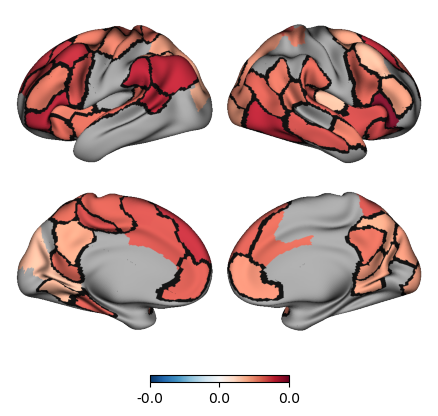

In [17]:
bad_ROIs = [30, 31, 32, 78, 79, 'hippocampus_R','hippocampus_L']

selected_nodes_contours_plot = [try_int(val) for val in selected_nodes_to_save['node']]
        

#Then want to just plot the ones that have the actual effects in them
selected_nodes_list = [try_int(val) for val in selected_nodes['node']]
vals = []
for node in range(100):
    if node in selected_nodes_list and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)


selected_nodes_contours_plot = [try_int(val) for val in selected_nodes_to_save['node']]
vals = []
for node in range(100):
    if node in selected_nodes_contours_plot and node not in bad_ROIs:
        vals.append(all_sub['estimate'][node])
    else:
        vals.append(np.nan)

new_array = map_values_to_atlas(atlas_surf, np.array(vals))

translucent_map = make_translucent_map(new_array, np.nanmax(np.abs(new_array))*.20, new_array)
translucent_map 

p = Plot(lh, rh, views=['lateral', 'medial'])

p.add_layer(translucent_map , cbar=True, cmap='RdBu_r', color_range=(-.003, .003), zero_transparent=False)

for region in selected_nodes_contours_plot:
    if region in selected_nodes_list and region not in bad_ROIs:
        p_plot = [0] * 100
        p_plot[region] = 1  # Mark the current region
        p_array = map_values_to_atlas(atlas_surf, p_plot)

        # Add this region as a separate layer
        p.add_layer(p_array, cmap=black_cmap, as_outline=True, cbar=False, outline_thickness=2)
        
fig = p.build()  

print(event_num)
fig.savefig(f'../../plots/Fig4._characters/01._character_rep_cortical_fig_lucy_{event_num}.png', dpi=300,transparent=True)



i


/Users/f004p59/miniconda3/envs/brainiak_py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().


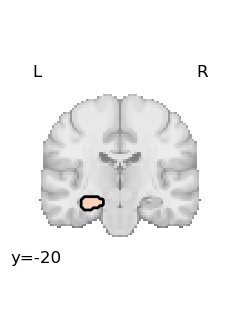

In [19]:

atlas_name = 'sub-maxprob-thr0-2mm'
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name)

atlas = harvard_oxford.maps

hippocampus_indices = [9, 19]
hippocampus_indices = [9, 19]  


hippocampus_mask_L = (atlas.get_fdata() == hippocampus_indices[0]).astype(int)
hippocampus_mask_R = (atlas.get_fdata() == hippocampus_indices[1]).astype(int)

# Combine masks into one
combined_mask = np.zeros(atlas.shape)

if 'hippocampus_L' in list(selected_nodes_to_save['node']):
    print('i')
    combined_mask[hippocampus_mask_L == 1] = all_sub['estimate'][100]
else:
    combined_mask[hippocampus_mask_L == 1] = 0
if 'hippocampus_R' in list(selected_nodes_to_save['node']):
    print('i')
    combined_mask[hippocampus_mask_R == 1] = all_sub['estimate'][101]
else:
    combined_mask[hippocampus_mask_R == 1] = 0
    
# Create a new Nifti image for the combined mask
combined_img = nib.Nifti1Image(combined_mask, atlas.affine)

# Plot the combined image
# display = plotting.plot_stat_map(combined_img, title='Hippocampus Values', display_mode='ortho', colorbar=False, cmap=single_cmap)
display = plotting.plot_stat_map(combined_img, display_mode='y', cut_coords=[-20], colorbar=False, cmap='RdBu_r', symmetric_cbar=True, vmax=.007)

if 'hippocampus_L' in selected_nodes_contours_plot:
    display.add_contours(nib.Nifti1Image(hippocampus_mask_L, atlas.affine), levels=[0.5], colors='black', linewidths=2)
if 'hippocampus_R' in selected_nodes_contours_plot:
    display.add_contours(nib.Nifti1Image(hippocampus_mask_R, atlas.affine), levels=[0.5], colors='black', linewidths=2)


display.savefig(f'../../plots/Fig4._characters/01._character_rep_cortical_fig_lucy_{event_num}_hippocampus.png', dpi=500)
